Plot some seismograms from AxiSEM3D


In [10]:
#### Modules
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


In [11]:
#### helper functions

def time_to_freq(time):

    freq = np.asarray(range(int(len(time)/2)+1),dtype = np.float32) / (time[-1] - time[0])
    return freq

def log_gabor_filter(freq, center_f, sigma):

    filt = np.zeros(len(freq), dtype = np.float32)
    filt[1:] = np.exp( -np.power(np.log(np.asarray(freq[1:])/center_f), 2.)  / (2. * np.power(np.log(sigma),2.)))
    return filt

def butter_lowpass_filter(freq, cutoff, order):

    filt = 1 / np.sqrt(1 + np.power(freq/cutoff, 2. * order))
    return filt

def cosine_taper(t, T1, T2):
    num_steps = len(t)
    taper = np.zeros(num_steps, dtype = np.float32)

    ### find start and end indices of time window
    ind_start = 0
    ind_end = 0
    
    for it in range(1, num_steps-1):
        if t[it-1] <= T1 and t[it]>=T1:
            ind_start = it-1
        if t[it-1] <= T2 and t[it]>=T2:
            ind_end = it        
    
    taper[ind_start:ind_end+1] = 1
    print(ind_start, ind_end)
    ### taper 30% before and after window length. make sure no undefined behavior.
    cut = int(30 * (ind_end-ind_start) / 100.)
    if cut<2:
        cut=2
    print(cut)
    ### fill taper
    cos_part = np.cos(3*np.pi/2. + np.pi/2. * ( np.asarray(range(cut), dtype = np.float32) /(cut-1)))
    taper[ind_start-cut:ind_start] = cos_part
    taper[ind_end+1:ind_end+1+cut] = np.flip(cos_part,0)

    return taper


Text(0,0.5,'Amplitude (m)')

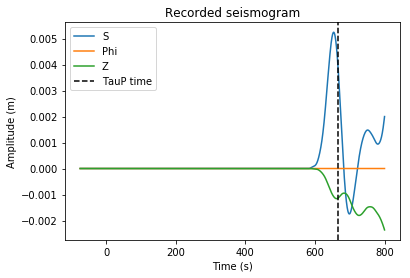

In [16]:
#### Inputs

INPUT_DIR = '/home/alex/Desktop/phd/private_Axisem3D/AxiSEM3D/build/output/stations/'
OUTPUT_DIR = '/home/alex/Desktop/phd/figures/seismograms/'

STATION = 'II.AAK.SPZ'

smgr = Dataset(INPUT_DIR + 'axisem3d_synthetics_fwd.nc', 'r')


time = smgr.variables['time_points'][:]
station = smgr.variables[STATION][:]
#freq = time_to_freq(time)

fig = plt.figure()
plt.title('Recorded seismogram')
plt.plot(time, station)
plt.axvline(x=664.956,color='k', linestyle='--')
plt.legend(['S','Phi','Z','TauP time'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')
#plt.savefig(OUTPUT_DIR+'misfittest_case5_forward_seismogram.png', dpi=300, bbox_inches='tight')




In [ ]:
#### Look at strain from master AxiSEM3D

INPUT_DIR = '/home/alex/Desktop/phd/master_axisem3d/AxiSEM3D/build/output/stations/'
OUTPUT_DIR = '/home/alex/Desktop/phd/figures/seismograms/'

STATION = 'II.AAK.RTZ.strain'

smgr = Dataset(INPUT_DIR + 'axisem3d_synthetics.nc', 'r')


time = smgr.variables['time_points'][:]
station = smgr.variables[STATION][:]
taper = cosine_taper(time, 580.,720.)

fig = plt.figure()
plt.title('Time windowed trace of strain')
plt.plot(time, taper * (station[:,0]+station[:,1]+station[:,2])) #trace of strain
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')

plt.savefig(OUTPUT_DIR+'traceStrain_S90N0E_R20N0E.png', dpi=300, bbox_inches='tight')

In [ ]:

filt = butter_lowpass_filter(freq, 1./30, 4)
plt.plot(freq[:100], filt[:100])
plt.title('Log_gabor filter. Tc=70s, sigma=0.7')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
#plt.savefig(OUTPUT_DIR+'case5_low_butter_filter.png', dpi=300, bbox_inches='tight')

In [ ]:
taper = cosine_taper(time, 460.,630.)
plt.plot(time,taper)
plt.title('Cosine taper, 30%. Time window T=[460s:630s]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.savefig(OUTPUT_DIR+'case5_cosine_taper.png', dpi=300, bbox_inches='tight')


In [ ]:
#### Some processing then plot 


s=np.squeeze(station[:,0])
s_t = taper*s
s_ft = taper * np.fft.irfft(2. * np.pi * filt* 1j * freq * np.fft.rfft(s), len(s) )
s_2ft = taper * np.fft.irfft(2. * np.pi * freq * 2. * np.pi * filt* 1j *1j * freq * np.fft.rfft(s), len(s) )
dt = time[1]-time[0]
norm = np.sum(dt*s_2ft*s)

plt.plot(time,s_ft)
#plt.plot(time,s_t)
plt.title('Processed velocity S component')
#plt.legend(['tapered and filtered velocity S component'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m/s)')
#plt.savefig(OUTPUT_DIR+'case5_Processed_S_seism.png', dpi=300, bbox_inches='tight')



In [ ]:
#### Plot adjoint source

#adj = np.flip(s_ft,0)
adj = np.zeros(len(s_ft))
for i in range(len(s_ft)-1):
    adj[i] = -s_ft[len(s_ft)-1-i] 
plt.plot(time, adj/norm)
plt.title('Adjoint source')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')
#plt.savefig(OUTPUT_DIR+'case3_adjoint_source.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
test2 = np.loadtxt(INPUT_DIR+"test.txt")
plt.plot(time,test2)
plt.title('Adjoint source (output from AxiSEM3D)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')

In [ ]:
### plot L1 seismogram difference between 1D and 3D

s1D = np.loadtxt(INPUT_DIR+'test1D.txt')
s3D = np.loadtxt(INPUT_DIR+'test.txt')
plt.plot(time,s1D)
plt.plot(time, s3D)
plt.xlim(400, 700)


In [ ]:
INPUT_DIR = '/home/alex/Desktop/phd/axisem3d_alex/AxiSEM3D/build/output/stations/'
OUTPUT_DIR = '/home/alex/Desktop/phd/figures/seismograms/'

STATION = 'II.AAK.SPZ'

smgr1D = Dataset(INPUT_DIR + 'axisem3d_synthetics_1D_dt0.01.nc', 'r')
smgr3D = Dataset(INPUT_DIR + 'axisem3d_synthetics_traveltime_0.05vp_610km_dt0.01.nc', 'r')

time = smgr1D.variables['time_points'][:]
station1D = smgr1D.variables[STATION][:]
station3D = smgr3D.variables[STATION][:]
freq = time_to_freq(time)

taper = cosine_taper(time, 460.,670.)
filt = butter_lowpass_filter(freq, 1./70., 4)


In [ ]:
dt = time[1]-time[0]
s1D=np.squeeze(station1D[:,0])
s_t1D = taper*s1D
s_ft1D = taper * np.fft.irfft( filt * np.fft.rfft(s1D), len(s1D) )

s3D=np.squeeze(station3D[:,0])
s_t3D = taper*s3D
s_ft3D = taper * np.fft.irfft( filt * np.fft.rfft(s3D), len(s3D) )

corr1, corr2 = np.correlate(s_ft1D,s_ft1D,'full'), np.correlate(s_ft1D,s_ft3D,'full')
delta_T = dt * (np.argmax(corr1)-np.argmax(corr2))
print(delta_T)

plt.plot(time,s_ft1D)
plt.plot(time,s_ft3D,'r')


In [ ]:
R_cyl = np.asarray([130,160,190,220,250,280,310,340,370,400,430,460,490,520,550,580,610])
dT_corr = np.asarray([0.26,0.32,0.40,0.48,0.57,0.68,0.79,0.91,1.03,1.19,1.34,1.51,1.69,1.88,2.08,2.30,2.53])
dT_ker = np.asarray([0.001149740,0.0014468599,0.00178057369,0.002152203140,0.0025605512542,0.003006292620,0.0034908099262,
                     0.004013593846,0.004573868364,0.005172478080,0.005808964591,0.006483368506,0.007194869292,
                     0.007941812371,0.008724373694,0.009541741861,0.010391172660])

dT_ratio = dT_corr/dT_ker

err = 0.01

import matplotlib
matplotlib.rcParams.update({'font.size': 16})


plt.errorbar(R_cyl,-dT_corr,yerr=err, fmt='o')
#plt.plot(R_cyl,-dT_corr,'*')
plt.xlabel('Radius cylinder (km)',fontsize=16)
#plt.ylabel('$\delta T_{corr}/\delta T_{ker}$',fontsize=16)
plt.ylabel('$\delta T_{corr}$ (s)',fontsize=16)
plt.savefig(OUTPUT_DIR+'dTcorr_Rcyl.png', dpi=300, bbox_inches='tight')